In [79]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_dataset_wise_metrics(stats, x_key='n_cells', figsize=(8, 6), y_range=None, text_sizes=None, save_path='figures/'):
    """
    Create separate figures for each disease type showing both F1 and Accuracy metrics on the same plot.
    Creates three figures: Heart Disease, Blood Disease, and Covid Disease.
    
    Parameters:
    - stats: dictionary with model data
    - x_key: key to use for x-axis (default: 'n_cells')
    - figsize: figure size tuple for each individual figure
    - y_range: tuple (min, max) for y-axis range, None for auto-scale
    - text_sizes: dict with text size controls
    - save_path: path to save the figures
    """
    
    # Default text sizes
    default_sizes = {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    if text_sizes is None:
        text_sizes = default_sizes
    else:
        text_sizes = {**default_sizes, **text_sizes}
    
    # Define disease types and their corresponding metrics
    diseases = {
        'heart_disease': {
            'title': 'Heart Disease Prediction',
            'f1_metrics': [],
            'acc_metrics': []
        },
        'blood_disease': {
            'title': 'Blood Disease Prediction',
            'f1_metrics': [],
            'acc_metrics': []
        },
        'covid_disease': {
            'title': 'Covid Disease Prediction',
            'f1_metrics': [],
            'acc_metrics': []
        }
    }
    
    # Find metrics for each disease type
    for key in next(iter(stats.values())).keys():
        if key != x_key and key != 'pretraining_hrs':  # Exclude x-axis and time
            # Skip cell_type and drug_response metrics
            if 'cell_type' in key.lower() or 'drug_response' in key.lower() or 'auc' in key.lower():
                continue
                
            for disease in diseases.keys():
                if disease in key:
                    if key.endswith('_f1'):
                        diseases[disease]['f1_metrics'].append(key)
                    elif key.endswith('_acc'):
                        diseases[disease]['acc_metrics'].append(key)
    
    # Colors for F1 and Accuracy
    f1_color = '#1f77b4'  # Blue
    acc_color = '#ff7f0e'  # Orange
    
    # Extract common data
    models = list(stats.keys())
    x_values = [stats[model][x_key] for model in models]
    
    figures = {}
    
    # Create figure for each disease type
    for disease_key, disease_info in diseases.items():
        # Skip if no metrics found for this disease
        if not disease_info['f1_metrics'] and not disease_info['acc_metrics']:
            continue
            
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Plot F1 scores
        for f1_metric in disease_info['f1_metrics']:
            y_values = [stats[model][f1_metric] for model in models]
            
            # Skip if all values are 0
            if all(y == 0 for y in y_values):
                continue
            
            ax.plot(x_values, y_values, 'o-', color=f1_color, 
                   linewidth=2, markersize=8, label='F1 Score')
            
            # Add value annotations
            for x, y, model in zip(x_values, y_values, models):
                if y > 0:
                    ax.annotate(f'{model}\n{y:.3f}', (x, y), 
                               textcoords="offset points", xytext=(0,-40), 
                               ha='center', fontsize=text_sizes['annotations'], alpha=0.7)
        
        # Plot Accuracy scores
        for acc_metric in disease_info['acc_metrics']:
            y_values = [stats[model][acc_metric] for model in models]
            
            # Skip if all values are 0
            if all(y == 0 for y in y_values):
                continue
            
            ax.plot(x_values, y_values, 's-', color=acc_color, 
                   linewidth=2, markersize=8, label='Accuracy')
            
            # Add value annotations
            for x, y, model in zip(x_values, y_values, models):
                if y > 0:
                    ax.annotate(f'{model}\n{y:.3f}', (x, y), 
                               textcoords="offset points", xytext=(0,10), 
                               ha='center', fontsize=text_sizes['annotations'], alpha=0.7)
        
        # Customize the plot
        ax.set_xlabel('Number of Cells', fontsize=text_sizes['axes_labels'])
        ax.set_ylabel('Score', fontsize=text_sizes['axes_labels'])
        ax.set_title(disease_info['title'], fontsize=text_sizes['title'], fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=text_sizes['legend'])
        ax.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])

        ax.margins(x=0.15, y=0.05)
        
        # Set y-axis range if specified
        if y_range is not None:
            ax.set_ylim(y_range[0], y_range[1])
        
        # Set x-axis to log scale if dealing with large numbers
        if max(x_values) > 1000000:
            ax.set_xscale('log')
            ax.set_xlabel('Number of Cells (log scale)', fontsize=text_sizes['axes_labels'])
        
        plt.tight_layout()
        
        # Save the figure
        filename = f'{save_path}{disease_key}_classification_vs_cells.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
        
        figures[disease_key] = fig
        
        plt.show()
    
    return figures

# Keep the original functions for other plotting needs
def plot_cell_type_metrics(stats, x_key='n_cells', title_prefix='Cell Type Classification: ', 
                          figsize=(16, 6), y_range=None, text_sizes=None):
    """
    Create side-by-side plots for cell type F1 and Accuracy metrics.
    Each dataset will be a separate line on both plots.
    
    Parameters:
    - stats: dictionary with model data
    - x_key: key to use for x-axis (default: 'n_cells')
    - title_prefix: prefix for plot titles
    - figsize: figure size tuple
    - y_range: tuple (min, max) for y-axis range, None for auto-scale
    - text_sizes: dict with text size controls
    """
    
    # Default text sizes
    default_sizes = {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    if text_sizes is None:
        text_sizes = default_sizes
    else:
        text_sizes = {**default_sizes, **text_sizes}
    
    # Find all cell_type metrics and group by dataset
    cell_type_datasets = defaultdict(lambda: {'f1': [], 'acc': []})
    
    for key in next(iter(stats.values())).keys():
        if 'cell_type' in key.lower():
            parts = key.split('_')
            dataset = parts[0]  # e.g., 'cellnexus'
            metric_type = parts[-1]  # 'f1' or 'acc'
            
            if metric_type in ['f1', 'acc']:
                cell_type_datasets[dataset][metric_type].append(key)
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Color palette for different datasets
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Extract common data
    models = list(stats.keys())
    x_values = [stats[model][x_key] for model in models]
    
    # Plot F1 scores
    dataset_idx = 0
    for dataset, metrics in cell_type_datasets.items():
        for f1_metric in metrics['f1']:
            y_values = [stats[model][f1_metric] for model in models]
            
            # Skip if all values are 0
            if all(y == 0 for y in y_values):
                continue
            
            # Create dataset label
            dataset_label = dataset.title()
            
            ax1.plot(x_values, y_values, 'o-', color=colors[dataset_idx % len(colors)], 
                    linewidth=2, markersize=8, label=dataset_label)
            
            # Add value annotations
            for x, y, model in zip(x_values, y_values, models):
                if y > 0:
                    ax1.annotate(f'{model}\n{y:.3f}', (x, y), 
                               textcoords="offset points", xytext=(0,10), 
                               ha='center', fontsize=text_sizes['annotations'], alpha=0.7)
        
        dataset_idx += 1
    
    # Plot Accuracy scores
    dataset_idx = 0
    for dataset, metrics in cell_type_datasets.items():
        for acc_metric in metrics['acc']:
            y_values = [stats[model][acc_metric] for model in models]
            
            # Skip if all values are 0
            if all(y == 0 for y in y_values):
                continue
            
            # Create dataset label
            dataset_label = dataset.title()
            
            ax2.plot(x_values, y_values, 'o-', color=colors[dataset_idx % len(colors)], 
                    linewidth=2, markersize=8, label=dataset_label)
            
            # Add value annotations
            for x, y, model in zip(x_values, y_values, models):
                if y > 0:
                    ax2.annotate(f'{model}\n{y:.3f}', (x, y), 
                               textcoords="offset points", xytext=(0,10), 
                               ha='center', fontsize=text_sizes['annotations'], alpha=0.7)
        
        dataset_idx += 1
    
    # Customize F1 plot
    ax1.set_xlabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax1.set_ylabel('F1 Score', fontsize=text_sizes['axes_labels'])
    ax1.set_title(f'{title_prefix}F1 Score', fontsize=text_sizes['title'], fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='lower left', fontsize=text_sizes['legend'])
    ax1.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    ax1.margins(x=0.15, y=0.05)
    
    # Customize Accuracy plot
    ax2.set_xlabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax2.set_ylabel('Accuracy', fontsize=text_sizes['axes_labels'])
    ax2.set_title(f'{title_prefix}Accuracy', fontsize=text_sizes['title'], fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='lower left', fontsize=text_sizes['legend'])
    ax2.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    ax2.margins(x=0.15, y=0.05)
    
    # Set y-axis range if specified
    if y_range is not None:
        ax1.set_ylim(y_range[0], y_range[1])
        ax2.set_ylim(y_range[0], y_range[1])
    
    # Set x-axis to log scale if dealing with large numbers
    if max(x_values) > 1000000:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        ax1.set_xlabel('Number of Cells (log scale)', fontsize=text_sizes['axes_labels'])
        ax2.set_xlabel('Number of Cells (log scale)', fontsize=text_sizes['axes_labels'])
    
    plt.tight_layout()
    return fig, (ax1, ax2)

def plot_training_time_vs_cells(stats, title='Training Time vs Number of Cells', figsize=(10, 6), y_range=None, text_sizes=None, use_log_scale=False):
    """
    Create a separate plot for training time vs number of cells.
    """
    
    # Default text sizes
    default_sizes = {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    if text_sizes is None:
        text_sizes = default_sizes
    else:
        text_sizes = {**default_sizes, **text_sizes}
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    models = list(stats.keys())
    x_values = [stats[model]['n_cells'] for model in models]
    y_values = [stats[model]['pretraining_hrs'] for model in models]
    
    ax.plot(x_values, y_values, 'o-', color='red', linewidth=2, markersize=8)
    
    # Add annotations
    for x, y, model in zip(x_values, y_values, models):
        ax.annotate(f'{model}\n{y:.1f}h', (x, y), 
                   textcoords="offset points", xytext=(0,10), 
                   ha='center', fontsize=text_sizes['annotations'])
    
    ax.set_xlabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax.set_ylabel('Pretraining Hours', fontsize=text_sizes['axes_labels'])
    ax.set_title(title, fontsize=text_sizes['title'], fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    ax.margins(x=0.15, y=0.05)
    
    # Set y-axis range if specified
    if y_range is not None:
        ax.set_ylim(y_range[0], y_range[1])
    
    
    if use_log_scale:
        # Set x-axis to log scale
        ax.set_xscale('log')
        ax.set_xlabel('Number of Cells (log scale)', fontsize=text_sizes['axes_labels'])
    else:
        ax.set_xlabel('Number of Cells', fontsize=text_sizes['axes_labels'])

    
    plt.tight_layout()
    return fig, ax

In [80]:
# Custom text sizes - make everything larger
custom_text_sizes = {
    'title': 20,
    'axes_labels': 20, 
    'ticks': 18,
    'annotations': 16,
    'legend': 16
}


# # Or just change specific elements
# small_annotations = {'annotations': 6}  # Only smaller annotations
# fig2, ax2 = plot_auc_metrics(stats, text_sizes=small_annotations)

# # Default behavior (pass None or omit parameter)
# fig3, ax3 = plot_training_time_vs_cells(stats)  # Uses defaults

In [81]:
# Example usage with your data
stats = {"singlecell": {"n_cells": 34_331_263, "pretraining_hrs": 144.0, "genecorpus_heart_disease_f1":0.812, "genecorpus_heart_disease_acc":0.844,"genecorpus_drug_response_auc":0.89, "cellnexus_blood_disease_f1":0.789, "cellnexus_blood_disease_acc":0.886, "cellnexus_covid_disease_f1":0.964, "cellnexus_covid_disease_acc":0.964, "cellnexus_cell_type_f1":0.962, "cellnexus_cell_type_acc":0.962},
        "metacell_2": {"n_cells": 17_065_723, "pretraining_hrs": 96.0, "genecorpus_heart_disease_f1":0.847, "genecorpus_heart_disease_acc":0.874,"genecorpus_drug_response_auc":0.91, "cellnexus_blood_disease_f1":0.794, "cellnexus_blood_disease_acc":0.803, "cellnexus_covid_disease_f1":0.958, "cellnexus_covid_disease_acc":0.959, "cellnexus_cell_type_f1":0.956, "cellnexus_cell_type_acc":0.956},
        "metacell_4": {"n_cells": 8_434_796, "pretraining_hrs": 52.18, "genecorpus_heart_disease_f1":0.838, "genecorpus_heart_disease_acc":0.864,"genecorpus_drug_response_auc":0.93, "cellnexus_blood_disease_f1":0.779, "cellnexus_blood_disease_acc":0.869, "cellnexus_covid_disease_f1":0.691, "cellnexus_covid_disease_acc":0.718, "cellnexus_cell_type_f1":0.954, "cellnexus_cell_type_acc":0.954},
        "metacell_8": {"n_cells": 4_092_828, "pretraining_hrs": 27.83, "genecorpus_heart_disease_f1":0.833, "genecorpus_heart_disease_acc":0.862,"genecorpus_drug_response_auc":0.92, "cellnexus_blood_disease_f1":0.795, "cellnexus_blood_disease_acc":0.900, "cellnexus_covid_disease_f1":0.763, "cellnexus_covid_disease_acc":0.776, "cellnexus_cell_type_f1":0.954, "cellnexus_cell_type_acc":0.954},
        "metacell_16": {"n_cells": 1_939_487, "pretraining_hrs": 13.34, "genecorpus_heart_disease_f1":0.840, "genecorpus_heart_disease_acc":0.873,"genecorpus_drug_response_auc":0.93, "cellnexus_blood_disease_f1":0.792, "cellnexus_blood_disease_acc":0.894, "cellnexus_covid_disease_f1":0.789, "cellnexus_covid_disease_acc":0.797, "cellnexus_cell_type_f1":0.957, "cellnexus_cell_type_acc":0.957},
}

Saved: figures/heart_disease_classification_vs_cells.png


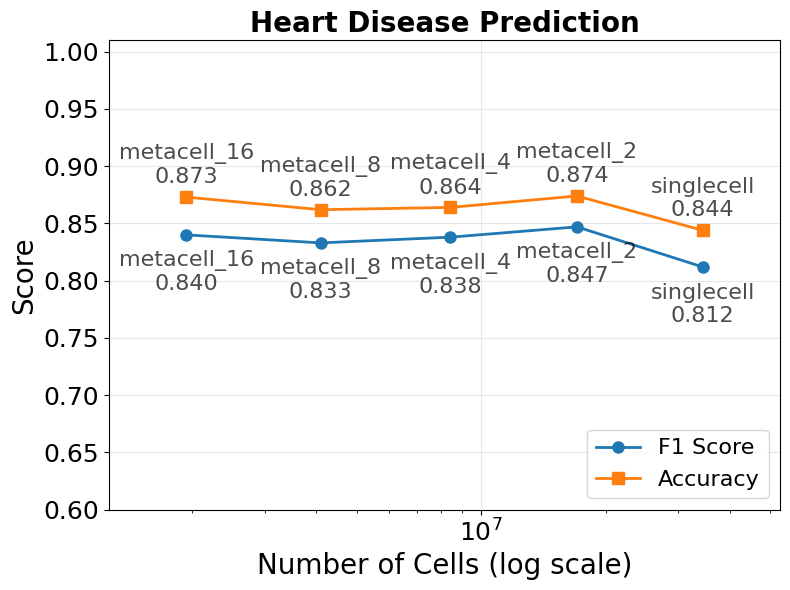

Saved: figures/blood_disease_classification_vs_cells.png


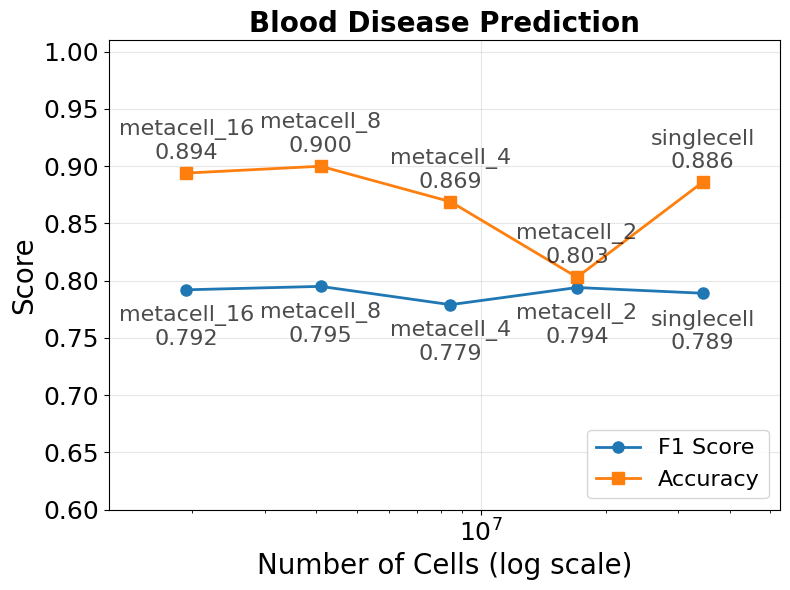

Saved: figures/covid_disease_classification_vs_cells.png


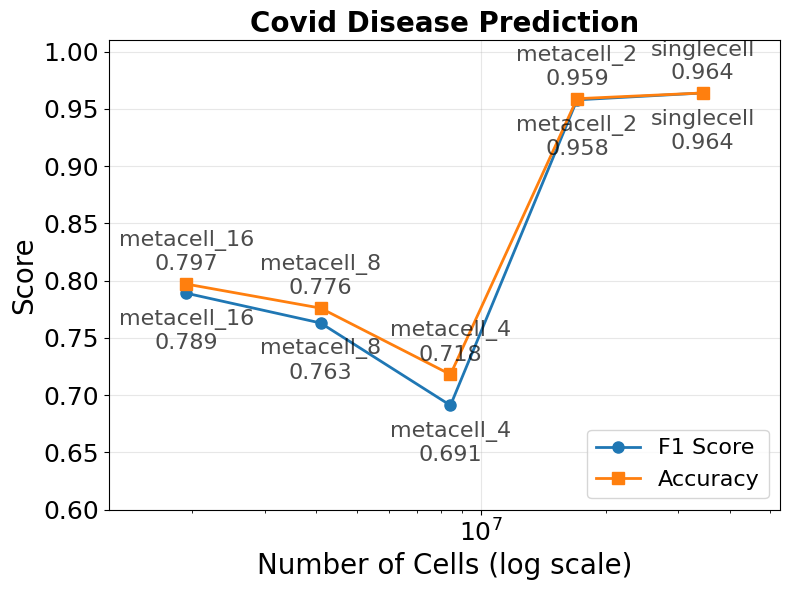

<Figure size 640x480 with 0 Axes>

In [82]:
# Create the plots
fig1, axes1, axes2 = plot_dataset_wise_metrics(stats, 
text_sizes=custom_text_sizes,
y_range=(0.60, 1.01))
plt.savefig('figures/model_performance_vs_cells.png', dpi=300)
plt.tight_layout()
plt.show()




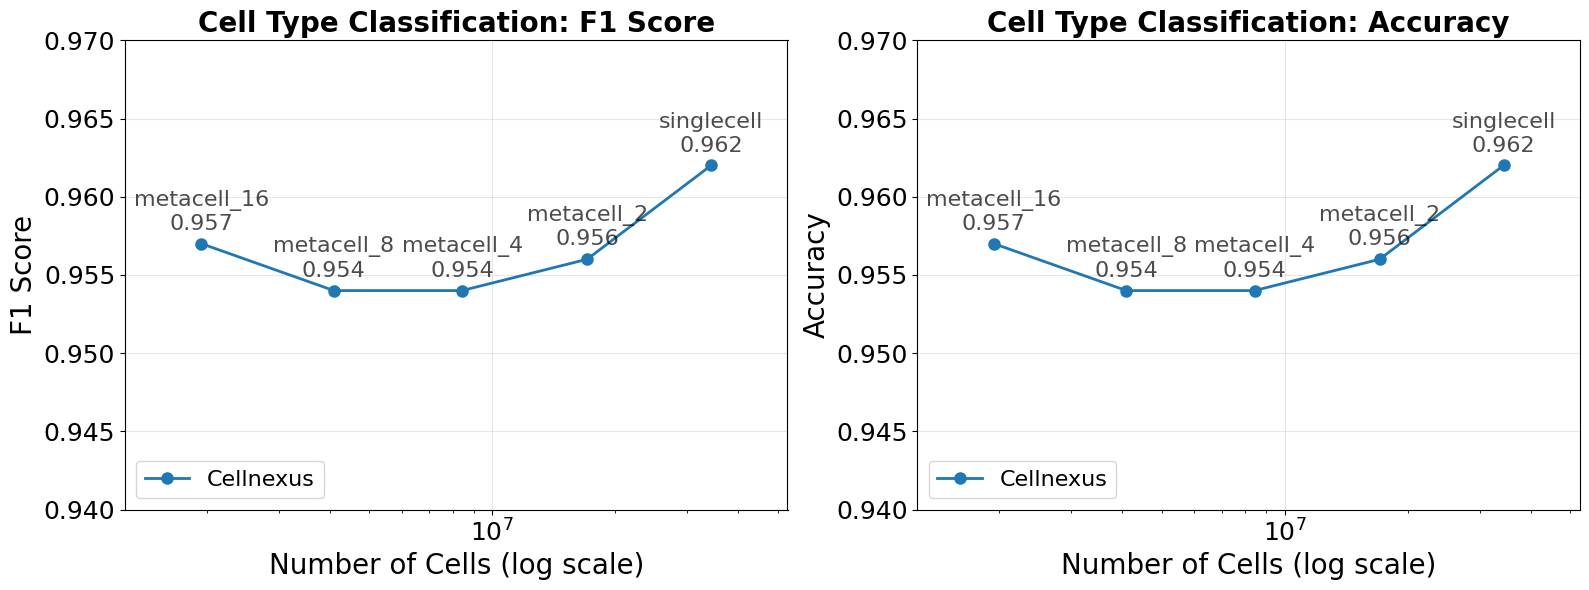

In [83]:
# Create the new cell type classification plots
fig2, (ax_f1, ax_acc) = plot_cell_type_metrics(stats, text_sizes=custom_text_sizes,
                                              y_range=(0.94, 0.97))
plt.savefig('figures/cell_type_performance_vs_cells.png', dpi=300, bbox_inches='tight')
plt.show()

# Just add more metrics with different dataset prefixes:
# "dataset2_cell_type_f1": 0.945, "dataset2_cell_type_acc": 0.945
# The plot_cell_type_metrics function will automatically detect and plot them as separate lines

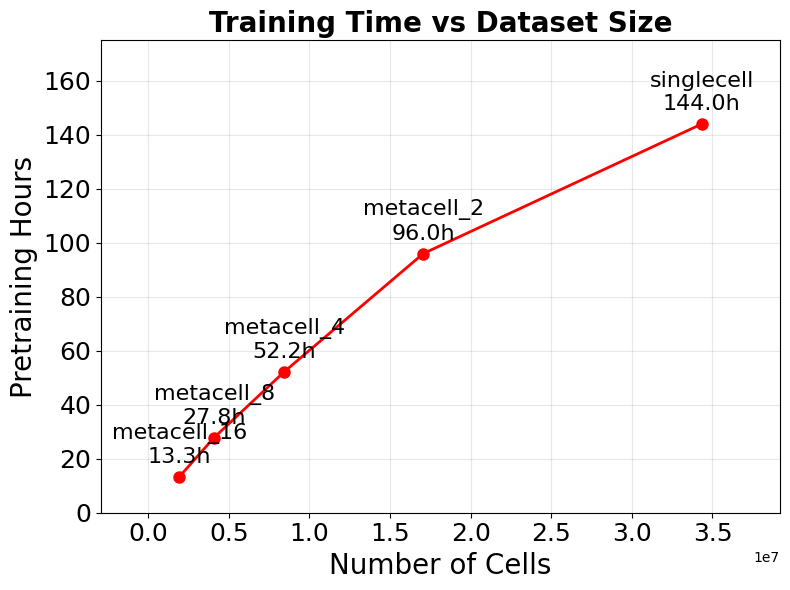

In [84]:
# Create training time plot
fig2, ax2 = plot_training_time_vs_cells(stats, title='Training Time vs Dataset Size',
text_sizes=custom_text_sizes, figsize=(8, 6),
y_range=(0, 175), use_log_scale=False)
plt.savefig('figures/training_time_vs_cells.png', dpi=300)
plt.tight_layout()
plt.show()

In [54]:
def plot_single_metric(stats, metric_key, title='', xlabel='Number of Cells', ylabel='AUC', figsize=(8, 6), y_range=None, text_sizes=None):
    """
    Create a single metric plot similar to your original image.
    
    Parameters:
    - stats: dictionary with model data
    - metric_key: key for the metric to plot
    - title: plot title
    - xlabel: x-axis label
    - ylabel: y-axis label
    - figsize: figure size tuple
    - y_range: tuple (min, max) for y-axis range, None for auto-scale
    - text_sizes: dict with text size controls {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    """
    
    # Default text sizes
    default_sizes = {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    if text_sizes is None:
        text_sizes = default_sizes
    else:
        # Merge with defaults for any missing keys
        text_sizes = {**default_sizes, **text_sizes}
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    models = list(stats.keys())
    x_values = [stats[model]['n_cells'] for model in models]
    y_values = [stats[model][metric_key] for model in models]
    
    ax.plot(x_values, y_values, 'o-', color='orange', linewidth=2, markersize=8)
    
    # Add model name annotations
    for x, y, model in zip(x_values, y_values, models):
        if y > 0:  # Only annotate non-zero values
            ax.annotate(f'{model}\n{y:.3f}', (x, y), 
                          textcoords="offset points", xytext=(0,10), 
                          ha='center', fontsize=text_sizes['annotations'], alpha=0.7)
    
    ax.set_xlabel(xlabel, fontsize=text_sizes['axes_labels'])
    ax.set_ylabel(ylabel, fontsize=text_sizes['axes_labels'])
    ax.set_title(title, fontsize=text_sizes['title'])
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    ax.margins(x=0.15, y=0.05)
    # Set y-axis range if specified
    if y_range is not None:
        ax.set_ylim(y_range[0], y_range[1])
    
    plt.tight_layout()
    return fig, ax

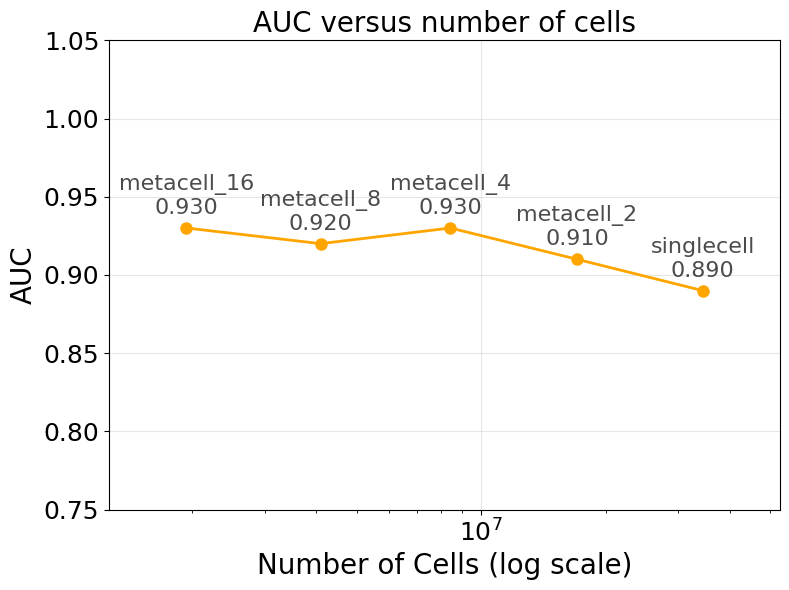

In [55]:
# Example: Recreate your original plot
fig3, ax3 = plot_single_metric(stats, 'genecorpus_drug_response_auc', 
                              title='AUC versus number of cells', 
                              ylabel='AUC',
                              xlabel='Number of Cells (log scale)',
                              text_sizes=custom_text_sizes,
y_range=(0.75, 1.05))
plt.savefig('figures/genecorpus_drug_response_auc_vs_cells.png', dpi=300)
plt.tight_layout()
plt.show()

In [ ]:

def plot_auc_metrics(stats, metric_key, title='', ylabel = '', figsize=(8, 6), y_range=None, text_sizes=None):
    """
    Create a separate plot for AUC metrics.
    
    Parameters:
    - stats: dictionary with model data
    - title: plot title
    - figsize: figure size tuple
    - y_range: tuple (min, max) for y-axis range, None for auto-scale
    - text_sizes: dict with text size controls {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    """
    
    # Default text sizes
    default_sizes = {'title': 14, 'axes_labels': 12, 'ticks': 10, 'annotations': 8, 'legend': 10}
    if text_sizes is None:
        text_sizes = default_sizes
    else:
        # Merge with defaults for any missing keys
        text_sizes = {**default_sizes, **text_sizes}
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Find AUC metrics
    auc_metrics = [key for key in next(iter(stats.values())).keys() if 'auc' in key.lower()]
    
    models = list(stats.keys())
    x_values = [stats[model]['n_cells'] for model in models]
    
    # Color palette for AUC metrics
    colors = ['#2ca02c', '#d62728', '#9467bd']  # Green and other colors
    
    for i, metric in enumerate(auc_metrics):
        y_values = [stats[model][metric] for model in models]
        
        # Skip if all values are 0
        if all(y == 0 for y in y_values):
            continue
            
        # Create clean metric name for legend
        metric_clean = metric.replace('genecorpus_', '').replace('_', ' ').title()
        
        ax.plot(x_values, y_values, 'o-', color=colors[i % len(colors)], 
               linewidth=2, markersize=8, label=metric_clean)
        
        # Add value annotations
        for x, y, model in zip(x_values, y_values, models):
            if y > 0:  # Only annotate non-zero values
                ax.annotate(f'{model}\n{y:.3f}', (x, y), 
                          textcoords="offset points", xytext=(0,10), 
                          ha='center', fontsize=text_sizes['annotations'], alpha=0.7)
    
    ax.set_xlabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax.set_ylabel(ylabel, fontsize=text_sizes['axes_labels'])
    print(title)
    ax.set_title(title, fontsize=text_sizes['title'], fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=text_sizes['legend'])
    ax.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    
    # Set y-axis range if specified
    if y_range is not None:
        ax.set_ylim(y_range[0], y_range[1])
    
    # Set x-axis to log scale
    if len(x_values) > 0 and max(x_values) > 1000000:
        ax.set_xscale('log')
        ax.set_xlabel('Number of Cells (log scale)', fontsize=text_sizes['axes_labels'])
    
    plt.tight_layout()
    return fig, ax

AUC Versus Number of Cells
blalka


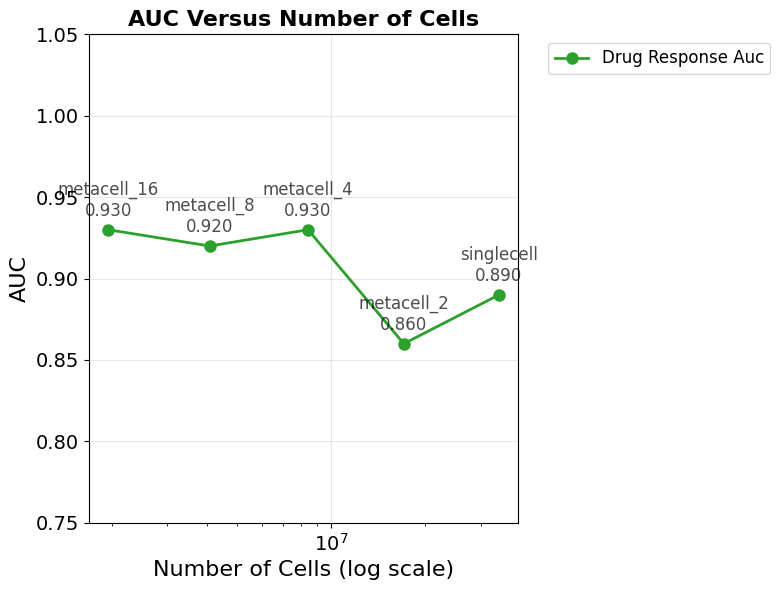

In [20]:
# Example: Recreate your original plot with custom y-range and text sizes
fig4, ax4 = plot_auc_metrics(stats, 'genecorpus_drug_response_auc', 
                              title='AUC Versus Number of Cells', 
                              ylabel='AUC', 
                              text_sizes=custom_text_sizes,
                              y_range=(0.75, 1.05))
                              
plt.savefig('figures/genecorpus_drug_response_auc_vs_cells.png', dpi=300)
plt.show()

# EDA of train/test split for cell type annotaitons dataset from CellNexus

Loading train dataset from: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/cell_type_classification/cellnexus_cell_types/30M_singlecell/cellnexus_cell_types_test_labeled_train.dataset
Saved train plot to: figures/cellnexus_train_cell_types.png

Train Dataset Statistics:
Total samples: 534094
Unique cell types: 51
Most common cell type: 8 (11250 samples)
Least common cell type: 48 (9000 samples)


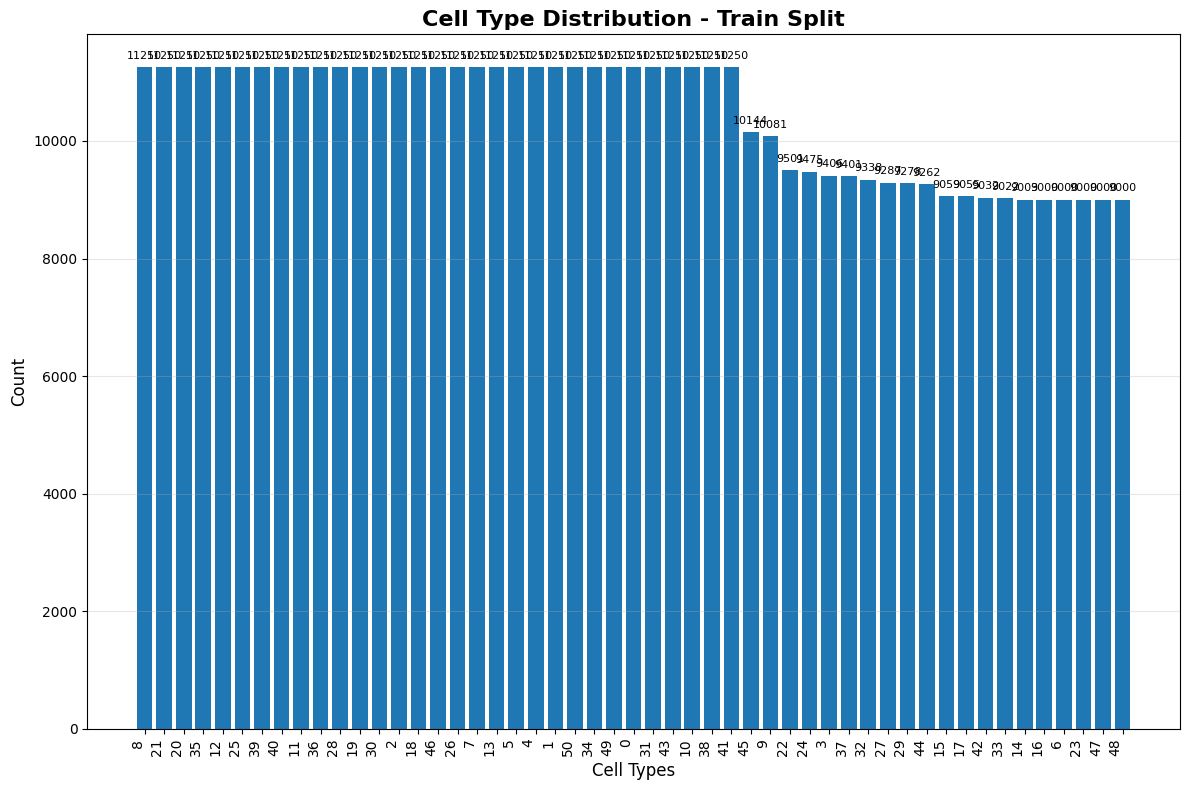

Loading test dataset from: /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/cell_type_classification/cellnexus_cell_types/30M_singlecell/cellnexus_cell_types_test_labeled_test.dataset
Saved test plot to: figures/cellnexus_test_cell_types.png

Test Dataset Statistics:
Total samples: 59344
Unique cell types: 51
Most common cell type: 34 (1250 samples)
Least common cell type: 16 (1000 samples)


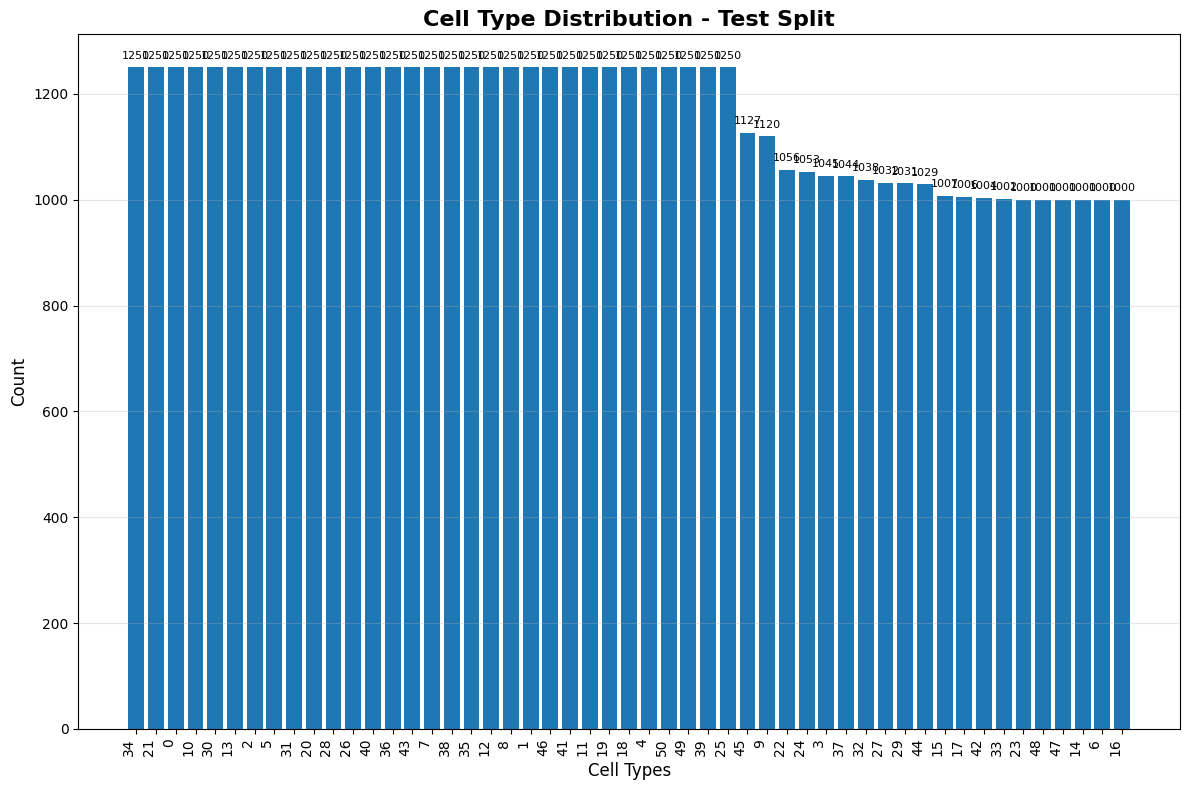

Saved total cells comparison plot to: figures/cellnexus_total_cells_comparison.png

Total Cells Comparison:
Train split: 534,094 cells
Test split: 59,344 cells
Total combined: 593,438 cells
Train/Test ratio: 9.00


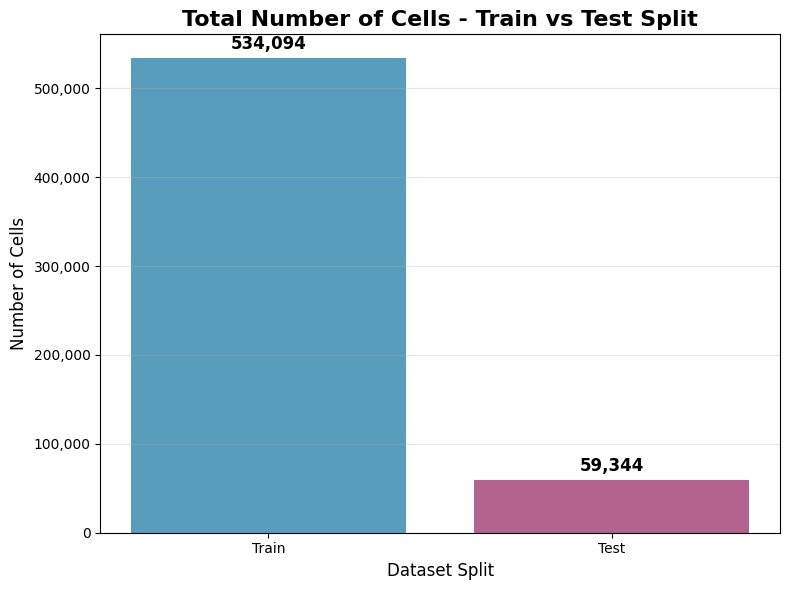


SUMMARY
Successfully processed both datasets!
Figures saved in: figures/
- Train plot: cellnexus_train_cell_types.png
- Test plot: cellnexus_test_cell_types.png
- Total cells comparison: cellnexus_total_cells_comparison.png


In [26]:
import os
import matplotlib.pyplot as plt
from datasets import load_from_disk
import pandas as pd
from collections import Counter

# Define paths
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/cell_type_classification/cellnexus_cell_types/30M_singlecell"
train_path = os.path.join(base_path, "cellnexus_cell_types_test_labeled_train.dataset")
test_path = os.path.join(base_path, "cellnexus_cell_types_test_labeled_test.dataset")

# Create figures directory if it doesn't exist
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

def load_and_plot_dataset(dataset_path, split_name, save_path):
    """Load dataset and create bar plot of cell_type counts"""
    
    # Load the dataset
    print(f"Loading {split_name} dataset from: {dataset_path}")
    dataset = load_from_disk(dataset_path)
    
    # Extract cell_type column
    cell_types = dataset['cell_type_backup']
    
    # Count occurrences of each cell type
    cell_type_counts = Counter(cell_types)
    
    # Convert to sorted lists for plotting
    cell_types_list = list(cell_type_counts.keys())
    counts_list = list(cell_type_counts.values())
    
    # Sort by count (descending) for better visualization
    sorted_data = sorted(zip(cell_types_list, counts_list), key=lambda x: x[1], reverse=True)
    sorted_cell_types, sorted_counts = zip(*sorted_data)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(sorted_cell_types)), sorted_counts)
    
    # Customize the plot
    plt.title(f'Cell Type Distribution - {split_name.title()} Split', fontsize=16, fontweight='bold')
    plt.xlabel('Cell Types', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Set x-axis labels with 90-degree rotation
    plt.xticks(range(len(sorted_cell_types)), sorted_cell_types, rotation=90, ha='right')
    
    # Add value labels on top of bars for better readability
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(sorted_counts)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3)
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved {split_name} plot to: {save_path}")
    
    # Show some statistics
    print(f"\n{split_name.title()} Dataset Statistics:")
    print(f"Total samples: {len(cell_types)}")
    print(f"Unique cell types: {len(cell_type_counts)}")
    print(f"Most common cell type: {sorted_cell_types[0]} ({sorted_counts[0]} samples)")
    print(f"Least common cell type: {sorted_cell_types[-1]} ({sorted_counts[-1]} samples)")
    
    plt.show()
    plt.close()
    
    return cell_type_counts

def plot_total_cells_comparison(train_counts, test_counts, save_path):
    """Create a bar plot comparing total number of cells in train and test splits"""
    
    # Calculate total cells in each split
    train_total = sum(train_counts.values())
    test_total = sum(test_counts.values())
    
    # Create the comparison plot
    plt.figure(figsize=(8, 6))
    
    splits = ['Train', 'Test']
    totals = [train_total, test_total]
    colors = ['#2E86AB', '#A23B72']  # Nice blue and purple colors
    
    bars = plt.bar(splits, totals, color=colors, alpha=0.8)
    
    # Customize the plot
    plt.title('Total Number of Cells - Train vs Test Split', fontsize=16, fontweight='bold')
    plt.ylabel('Number of Cells', fontsize=12)
    plt.xlabel('Dataset Split', fontsize=12)
    
    # Add value labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(totals)*0.01,
                f'{int(height):,}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3)
    
    # Format y-axis with commas for thousands
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved total cells comparison plot to: {save_path}")
    
    # Print comparison statistics
    print(f"\nTotal Cells Comparison:")
    print(f"Train split: {train_total:,} cells")
    print(f"Test split: {test_total:,} cells")
    print(f"Total combined: {train_total + test_total:,} cells")
    print(f"Train/Test ratio: {train_total/test_total:.2f}")
    
    plt.show()
    plt.close()

# Process both datasets
try:
    # Load and plot train dataset
    train_save_path = os.path.join(figures_dir, "cellnexus_train_cell_types.png")
    train_counts = load_and_plot_dataset(train_path, "train", train_save_path)
    
    # Load and plot test dataset
    test_save_path = os.path.join(figures_dir, "cellnexus_test_cell_types.png")
    test_counts = load_and_plot_dataset(test_path, "test", test_save_path)
    
    # Create total cells comparison plot
    total_cells_save_path = os.path.join(figures_dir, "cellnexus_total_cells_comparison.png")
    plot_total_cells_comparison(train_counts, test_counts, total_cells_save_path)
    
    print("\n" + "="*50)
    print("SUMMARY")
    print("="*50)
    print(f"Successfully processed both datasets!")
    print(f"Figures saved in: {figures_dir}/")
    print(f"- Train plot: cellnexus_train_cell_types.png")
    print(f"- Test plot: cellnexus_test_cell_types.png")
    print(f"- Total cells comparison: cellnexus_total_cells_comparison.png")
    
except Exception as e:
    print(f"Error processing datasets: {str(e)}")
    print("Please make sure:")
    print("1. The dataset paths are correct")
    print("2. You have the required libraries installed: datasets, matplotlib, pandas")
    print("3. You have read permissions for the dataset files")

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
import os

def plot_train_test_comparison(train_path, test_path, title="Dataset Split Comparison", 
                              text_sizes=None, figsize=(10, 6)):
    """
    Plot total number of cells in train vs test splits.
    
    Parameters:
    -----------
    train_path : str
        Path to the training dataset
    test_path : str
        Path to the test dataset
    title : str
        Title for the plot
    text_sizes : dict
        Dictionary containing text sizes for different elements
    figsize : tuple
        Figure size as (width, height)
    """
    
    # Default text sizes
    if text_sizes is None:
        text_sizes = {
            'title': 16,
            'axes_labels': 16, 
            'ticks': 14,
            'annotations': 12,
            'legend': 12
        }
    
    # Load datasets
    train_dataset = load_from_disk(train_path)
    test_dataset = load_from_disk(test_path)
    
    # Get counts
    train_count = len(train_dataset)
    test_count = len(test_dataset)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Data for plotting
    splits = ['Train', 'Test']
    counts = [train_count, test_count]
    
    # Create bar plot
    bars = ax.bar(splits, counts, color=['#2E86AB', '#A23B72'], alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Dataset Split', fontsize=text_sizes['axes_labels'])
    ax.set_ylabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax.set_title(title, fontsize=text_sizes['title'], pad=20)
    
    # Format y-axis to show numbers with commas
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Set tick sizes
    ax.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    
    # Add annotations on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count:,}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=text_sizes['annotations'],
                   fontweight='bold')
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    return fig, ax


def plot_class_distribution(train_path, test_path, title_prefix="Class Distribution", 
                           text_sizes=None, figsize=(12, 5)):
    """
    Plot class distribution for both train and test splits side by side.
    
    Parameters:
    -----------
    train_path : str
        Path to the training dataset
    test_path : str
        Path to the test dataset
    title_prefix : str
        Prefix for the plot titles
    text_sizes : dict
        Dictionary containing text sizes for different elements
    figsize : tuple
        Figure size as (width, height)
    """
    
    # Default text sizes
    if text_sizes is None:
        text_sizes = {
            'title': 16,
            'axes_labels': 16, 
            'ticks': 14,
            'annotations': 12,
            'legend': 12
        }
    
    # Load datasets
    train_dataset = load_from_disk(train_path)
    test_dataset = load_from_disk(test_path)
    
    # Get class distributions
    train_labels = train_dataset['label']
    test_labels = test_dataset['label']
    
    # Count occurrences of each label
    train_label_counts = {}
    test_label_counts = {}
    
    for label in train_labels:
        train_label_counts[label] = train_label_counts.get(label, 0) + 1
    
    for label in test_labels:
        test_label_counts[label] = test_label_counts.get(label, 0) + 1
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot train distribution
    train_classes = list(train_label_counts.keys())
    train_counts = list(train_label_counts.values())
    
    bars1 = ax1.bar(range(len(train_classes)), train_counts, 
                    color='#2E86AB', alpha=0.8)
    ax1.set_xlabel('Class Labels', fontsize=text_sizes['axes_labels'])
    ax1.set_ylabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax1.set_title(f'{title_prefix} - Train', fontsize=text_sizes['title'])
    ax1.set_xticks(range(len(train_classes)))
    ax1.set_xticklabels(train_classes, rotation=45, ha='right')
    ax1.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    ax1.margins(x=0.05, y=0.25)
    
    # Add annotations for train
    for bar, count in zip(bars1, train_counts):
        height = bar.get_height()
        ax1.annotate(f'{count:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=text_sizes['annotations'],
                    rotation=90 if len(str(count)) > 4 else 0)
    
    # Plot test distribution
    test_classes = list(test_label_counts.keys())
    test_counts = list(test_label_counts.values())
    
    bars2 = ax2.bar(range(len(test_classes)), test_counts, 
                    color='#A23B72', alpha=0.8)
    ax2.set_xlabel('Class Labels', fontsize=text_sizes['axes_labels'])
    ax2.set_ylabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax2.set_title(f'{title_prefix} - Test', fontsize=text_sizes['title'])
    ax2.set_xticks(range(len(test_classes)))
    ax2.set_xticklabels(test_classes, rotation=45, ha='right')
    ax2.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    ax2.margins(x=0.05, y=0.15)
    
    # Add annotations for test
    for bar, count in zip(bars2, test_counts):
        height = bar.get_height()
        ax2.annotate(f'{count:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=text_sizes['annotations'],
                    rotation=90 if len(str(count)) > 4 else 0)
    
    # Format y-axis to show numbers with commas
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add grid for better readability
    ax1.grid(axis='y', alpha=0.3)
    ax2.grid(axis='y', alpha=0.3)
    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)
    
    plt.tight_layout()
    return fig, (ax1, ax2)


    

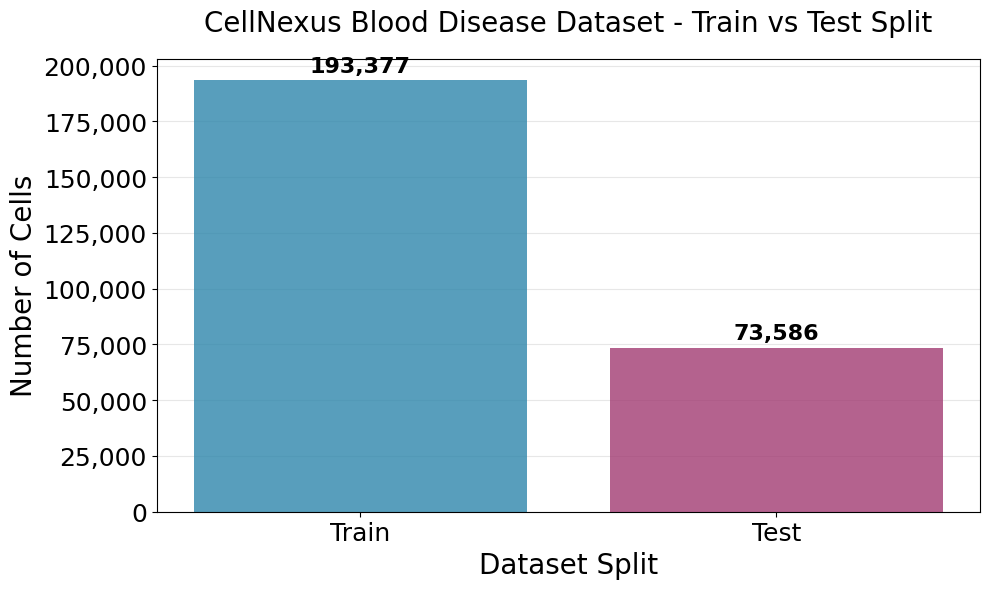

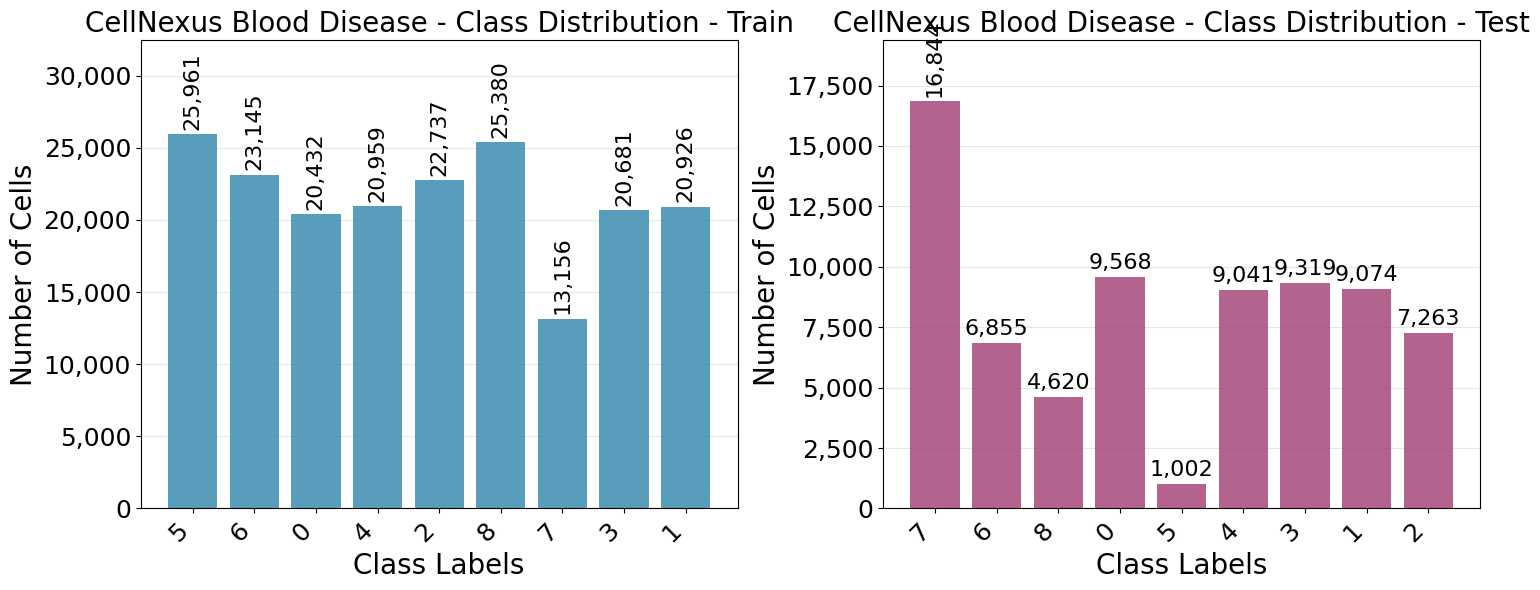

In [66]:
# Define custom text sizes
custom_text_sizes = {
    'title': 20,
    'axes_labels': 20, 
    'ticks': 18,
    'annotations': 16,
    'legend': 16
}

# Define paths
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/disease_classification/cellnexus_blood_disease/30M_singlecell.old"
train_path = os.path.join(base_path, "cellnexus_blood_disease_test_labeled_train.dataset")
test_path = os.path.join(base_path, "cellnexus_blood_disease_test_labeled_test.dataset")

# Plot 1: Train vs Test comparison
fig1, ax1 = plot_train_test_comparison(
    train_path=train_path,
    test_path=test_path,
    title="CellNexus Blood Disease Dataset - Train vs Test Split",
    text_sizes=custom_text_sizes,
    figsize=(10, 6)
)
plt.show()

# Plot 2: Class distribution
fig2, (ax2, ax3) = plot_class_distribution(
    train_path=train_path,
    test_path=test_path,
    title_prefix="CellNexus Blood Disease - Class Distribution",
    text_sizes=custom_text_sizes,
    figsize=(15, 6)
)
plt.show()

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
import os
import pickle

def plot_train_test_comparison(train_path, test_path, title="Dataset Split Comparison", 
                              text_sizes=None, figsize=(10, 6), ylim=None):
    """
    Plot total number of cells in train vs test splits.
    
    Parameters:
    -----------
    train_path : str
        Path to the training dataset
    test_path : str
        Path to the test dataset
    title : str
        Title for the plot
    text_sizes : dict
        Dictionary containing text sizes for different elements
    figsize : tuple
        Figure size as (width, height)
    ylim : tuple or None
        Y-axis limits as (min, max). If None, uses automatic scaling
    """
    
    # Default text sizes
    if text_sizes is None:
        text_sizes = {
            'title': 16,
            'axes_labels': 16, 
            'ticks': 14,
            'annotations': 12,
            'legend': 12
        }
    
    # Load datasets
    train_dataset = load_from_disk(train_path)
    test_dataset = load_from_disk(test_path)
    
    # Get counts
    train_count = len(train_dataset)
    test_count = len(test_dataset)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Data for plotting
    splits = ['Train', 'Test']
    counts = [train_count, test_count]
    
    # Create bar plot
    bars = ax.bar(splits, counts, color=['#2E86AB', '#A23B72'], alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Dataset Split', fontsize=text_sizes['axes_labels'])
    ax.set_ylabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax.set_title(title, fontsize=text_sizes['title'], pad=20)
    
    # Format y-axis to show numbers with commas
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Set tick sizes
    ax.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    
    # Add annotations on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count:,}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=text_sizes['annotations'],
                   fontweight='bold')
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Set y-axis limits if provided
    if ylim is not None:
        ax.set_ylim(ylim)
    
    plt.tight_layout()
    return fig, ax


def plot_class_distribution(train_path, test_path, id_class_dict_path, title_prefix="Class Distribution", 
                           text_sizes=None, figsize=(12, 5), ylim=None):
    """
    Plot class distribution for both train and test splits side by side.
    
    Parameters:
    -----------
    train_path : str
        Path to the training dataset
    test_path : str
        Path to the test dataset
    id_class_dict_path : str
        Path to the pickle file containing id to class label mapping
    title_prefix : str
        Prefix for the plot titles
    text_sizes : dict
        Dictionary containing text sizes for different elements
    figsize : tuple
        Figure size as (width, height)
    ylim : tuple or None
        Y-axis limits as (min, max). If None, uses automatic scaling
    """
    
    # Default text sizes
    if text_sizes is None:
        text_sizes = {
            'title': 16,
            'axes_labels': 16, 
            'ticks': 14,
            'annotations': 12,
            'legend': 12
        }
    
    # Load datasets
    train_dataset = load_from_disk(train_path)
    test_dataset = load_from_disk(test_path)
    
    # Load id to class mapping
    with open(id_class_dict_path, 'rb') as f:
        id_class_dict = pickle.load(f)
    
    # Get class distributions
    train_labels = train_dataset['label']
    test_labels = test_dataset['label']
    
    # Count occurrences of each label (using numerical IDs first)
    train_label_counts = {}
    test_label_counts = {}
    
    for label in train_labels:
        train_label_counts[label] = train_label_counts.get(label, 0) + 1
    
    for label in test_labels:
        test_label_counts[label] = test_label_counts.get(label, 0) + 1
    
    # Convert numerical IDs to human-readable class names
    train_class_counts = {}
    test_class_counts = {}
    
    for label_id, count in train_label_counts.items():
        class_name = id_class_dict.get(label_id, f"Unknown_{label_id}")
        train_class_counts[class_name] = count
    
    for label_id, count in test_label_counts.items():
        class_name = id_class_dict.get(label_id, f"Unknown_{label_id}")
        test_class_counts[class_name] = count
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot train distribution
    train_classes = list(train_class_counts.keys())
    train_counts = list(train_class_counts.values())
    
    bars1 = ax1.bar(range(len(train_classes)), train_counts, 
                    color='#2E86AB', alpha=0.8)
    ax1.set_xlabel('Class Labels', fontsize=text_sizes['axes_labels'])
    ax1.set_ylabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax1.set_title(f'{title_prefix} - Train', fontsize=text_sizes['title'])
    ax1.set_xticks(range(len(train_classes)))
    ax1.set_xticklabels(train_classes, rotation=45, ha='right')
    ax1.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    
    # Add annotations for train
    for bar, count in zip(bars1, train_counts):
        height = bar.get_height()
        ax1.annotate(f'{count:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=text_sizes['annotations'],
                    rotation=90 if len(str(count)) > 4 else 0)
    
    # Plot test distribution
    test_classes = list(test_class_counts.keys())
    test_counts = list(test_class_counts.values())
    
    bars2 = ax2.bar(range(len(test_classes)), test_counts, 
                    color='#A23B72', alpha=0.8)
    ax2.set_xlabel('Class Labels', fontsize=text_sizes['axes_labels'])
    ax2.set_ylabel('Number of Cells', fontsize=text_sizes['axes_labels'])
    ax2.set_title(f'{title_prefix} - Test', fontsize=text_sizes['title'])
    ax2.set_xticks(range(len(test_classes)))
    ax2.set_xticklabels(test_classes, rotation=45, ha='right')
    ax2.tick_params(axis='both', which='major', labelsize=text_sizes['ticks'])
    
    # Add annotations for test
    for bar, count in zip(bars2, test_counts):
        height = bar.get_height()
        ax2.annotate(f'{count:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=text_sizes['annotations'],
                    rotation=90 if len(str(count)) > 4 else 0)
    
    # Format y-axis to show numbers with commas
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add grid for better readability
    ax1.grid(axis='y', alpha=0.3)
    ax2.grid(axis='y', alpha=0.3)
    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)
    
    # Set y-axis limits if provided
    if ylim is not None:
        ax1.set_ylim(ylim)
        ax2.set_ylim(ylim)
    
    plt.tight_layout()
    return fig, (ax1, ax2)




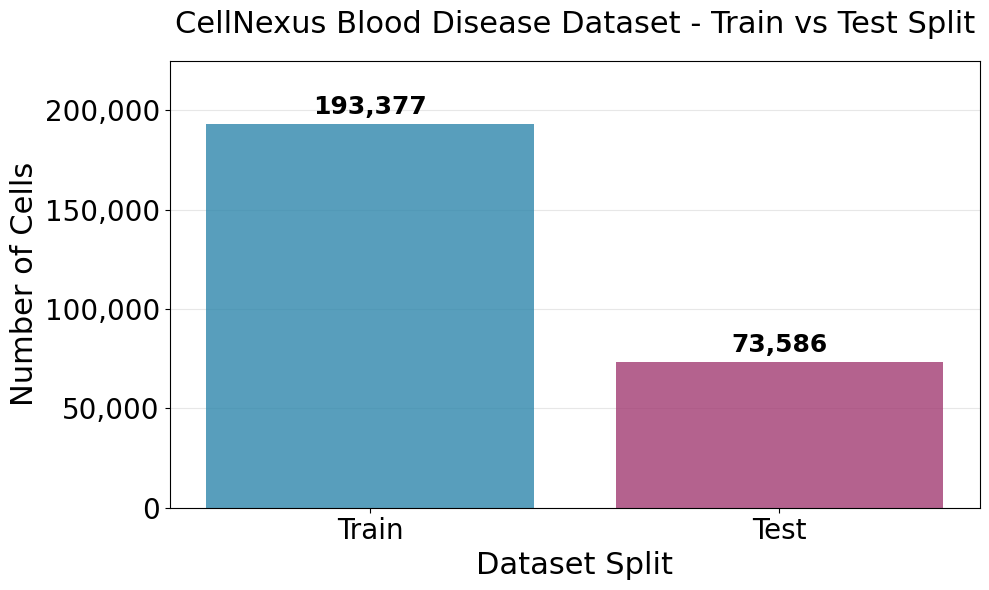

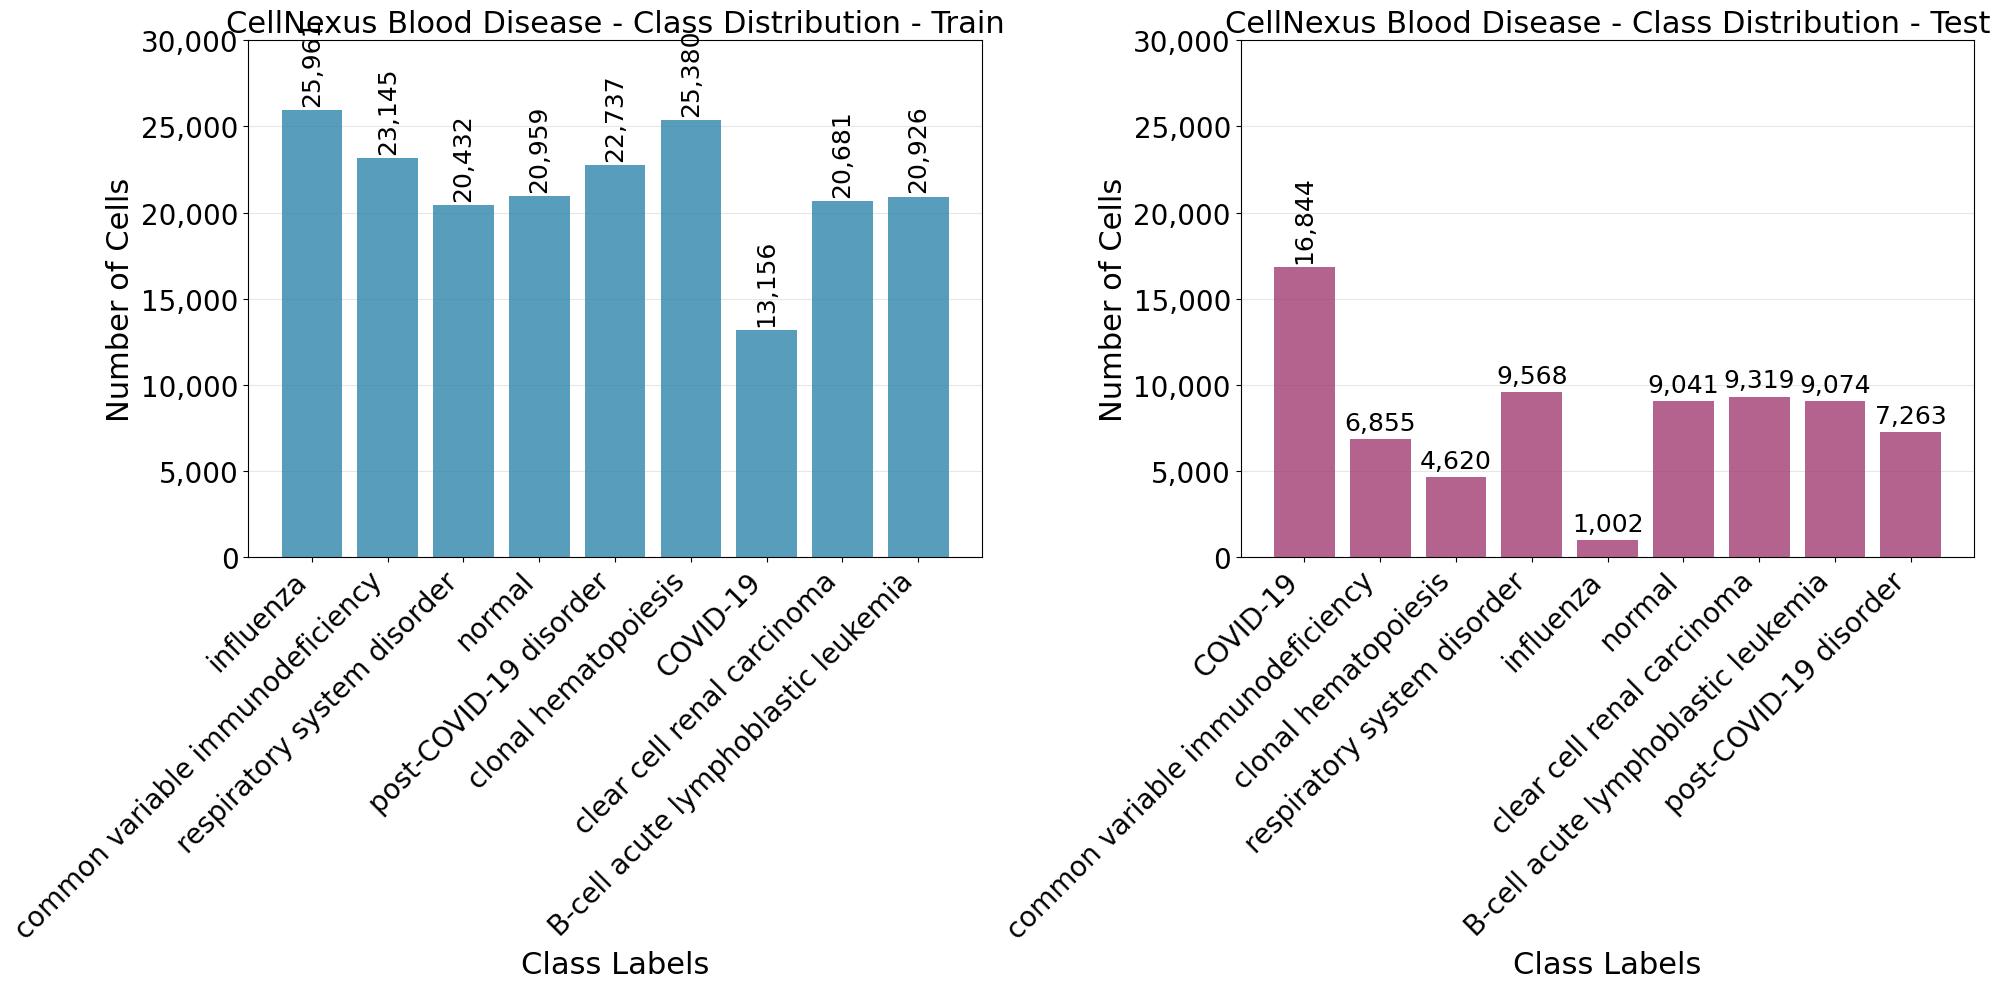

In [76]:
# Define custom text sizes
# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Define paths
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/disease_classification/cellnexus_blood_disease/30M_singlecell.old"
train_path = os.path.join(base_path, "cellnexus_blood_disease_test_labeled_train.dataset")
test_path = os.path.join(base_path, "cellnexus_blood_disease_test_labeled_test.dataset")

# Plot 1: Train vs Test comparison
fig1, ax1 = plot_train_test_comparison(
    train_path=train_path,
    test_path=test_path,
    title="CellNexus Blood Disease Dataset - Train vs Test Split",
    text_sizes=custom_text_sizes,
    figsize=(10, 6),
    ylim=(0, 225000)  # None or set to (0, 1000000) for example
)
plt.show()

# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Plot 2: Class distribution
id_class_dict_path = os.path.join(base_path, "cellnexus_blood_disease_test_id_class_dict.pkl")
fig2, (ax2, ax3) = plot_class_distribution(
    train_path=train_path,
    test_path=test_path,
    id_class_dict_path=id_class_dict_path,
    title_prefix="CellNexus Blood Disease - Class Distribution",
    text_sizes=custom_text_sizes,
    figsize=(20, 10),
    ylim=(0, 30000)  # None or set to (0, 500000) for example
)
plt.show()

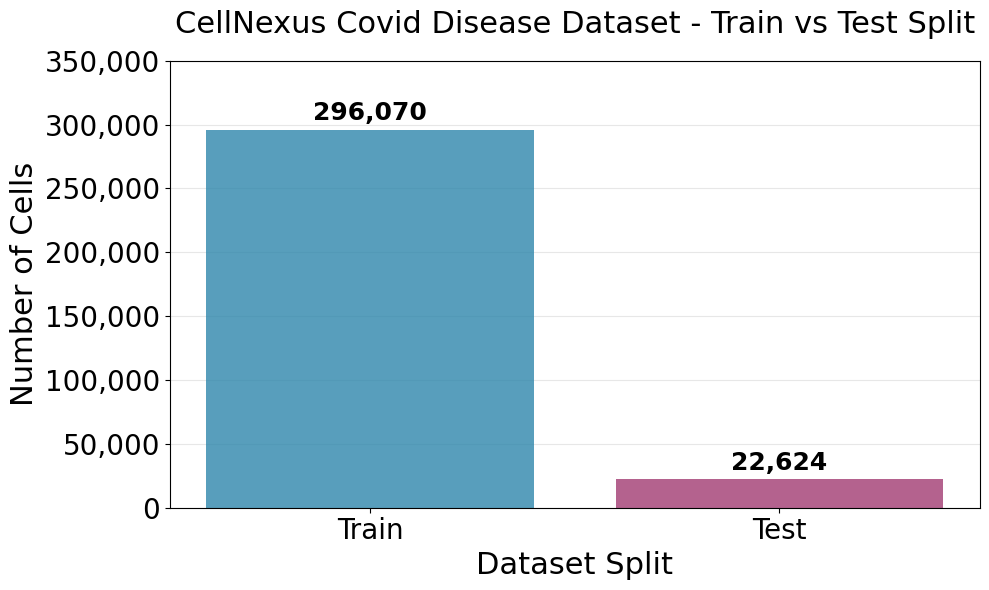

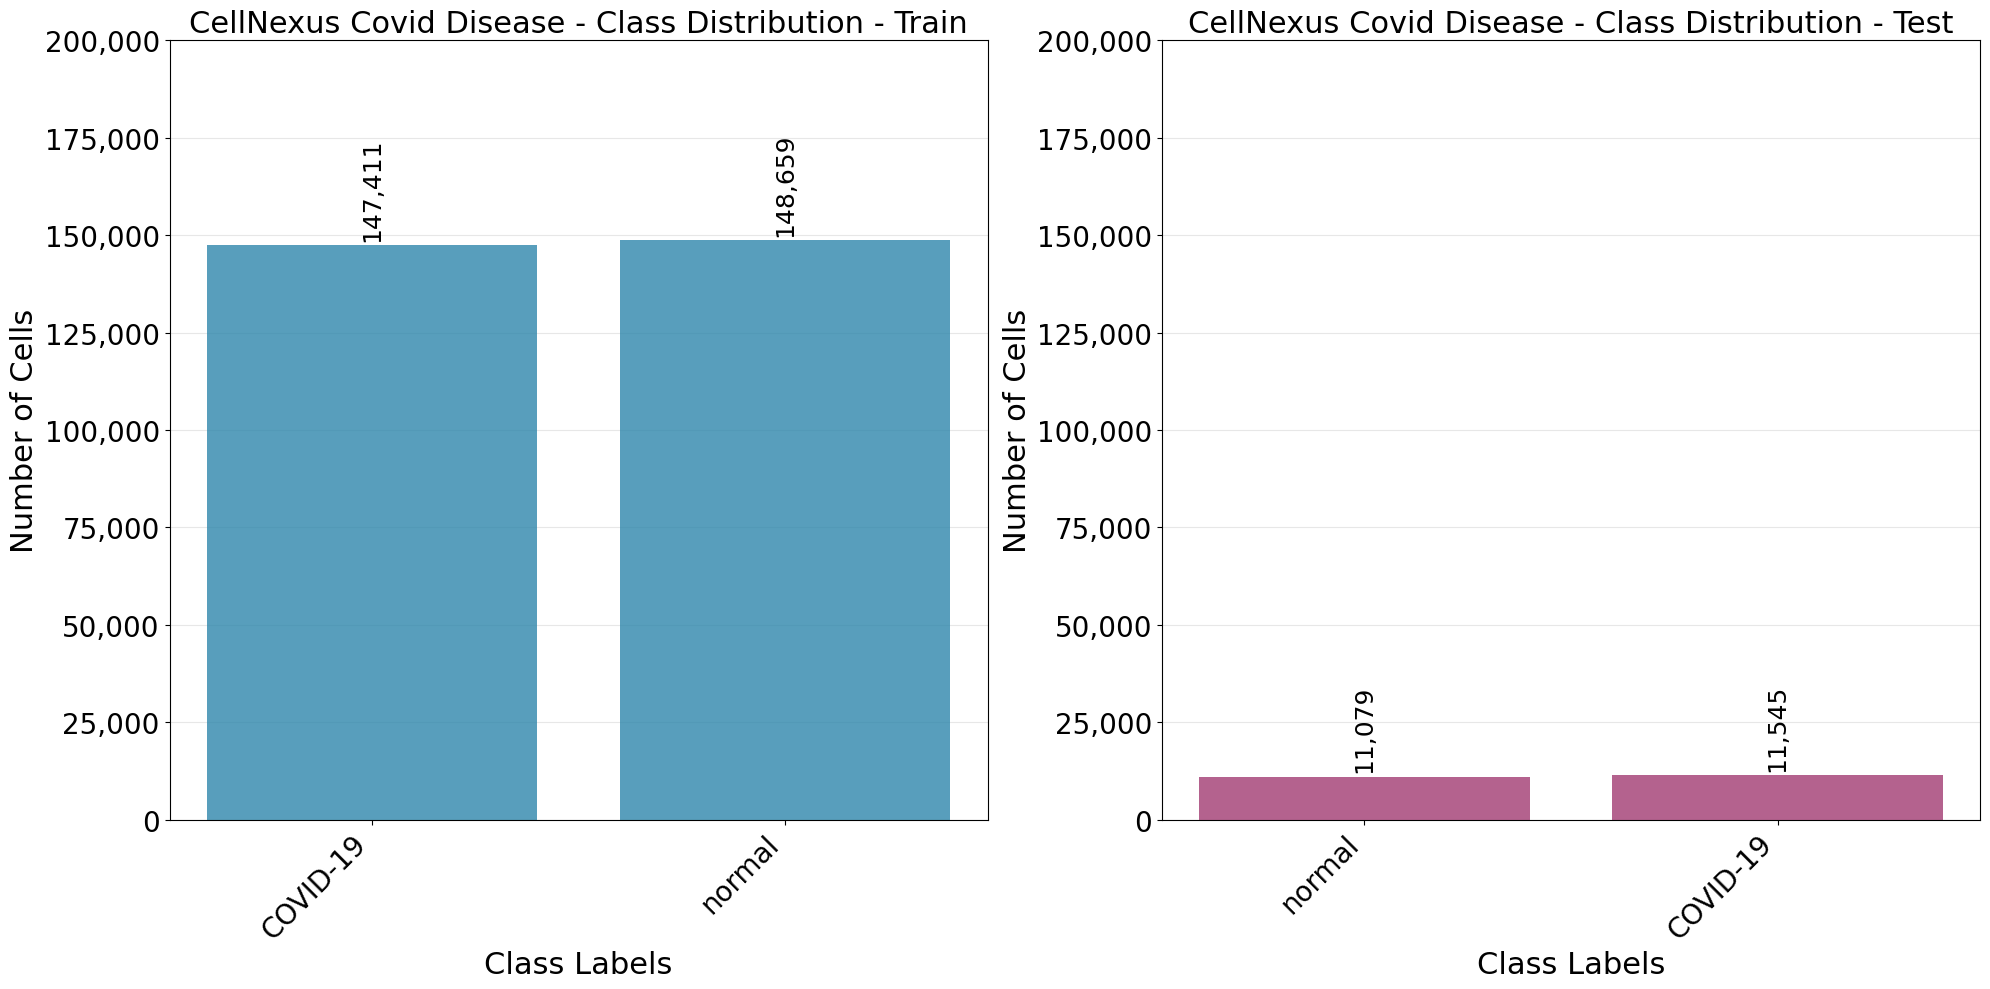

In [75]:
# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Define paths
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/disease_classification/cellnexus_covid_disease/30M_singlecell"
train_path = os.path.join(base_path, "cellnexus_covid_disease_test_labeled_train.dataset")
test_path = os.path.join(base_path, "cellnexus_covid_disease_test_labeled_test.dataset")

# Plot 1: Train vs Test comparison
fig1, ax1 = plot_train_test_comparison(
    train_path=train_path,
    test_path=test_path,
    title="CellNexus Covid Disease Dataset - Train vs Test Split",
    text_sizes=custom_text_sizes,
    figsize=(10, 6),
    ylim=(0, 350000)  # None or set to (0, 1000000) for example
)
plt.show()

# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Plot 2: Class distribution
id_class_dict_path = os.path.join(base_path, "cellnexus_covid_disease_test_id_class_dict.pkl")
fig2, (ax2, ax3) = plot_class_distribution(
    train_path=train_path,
    test_path=test_path,
    id_class_dict_path=id_class_dict_path,
    title_prefix="CellNexus Covid Disease - Class Distribution",
    text_sizes=custom_text_sizes,
    figsize=(20, 10),
    ylim=(0, 200000)  # None or set to (0, 500000) for example
)
plt.show()

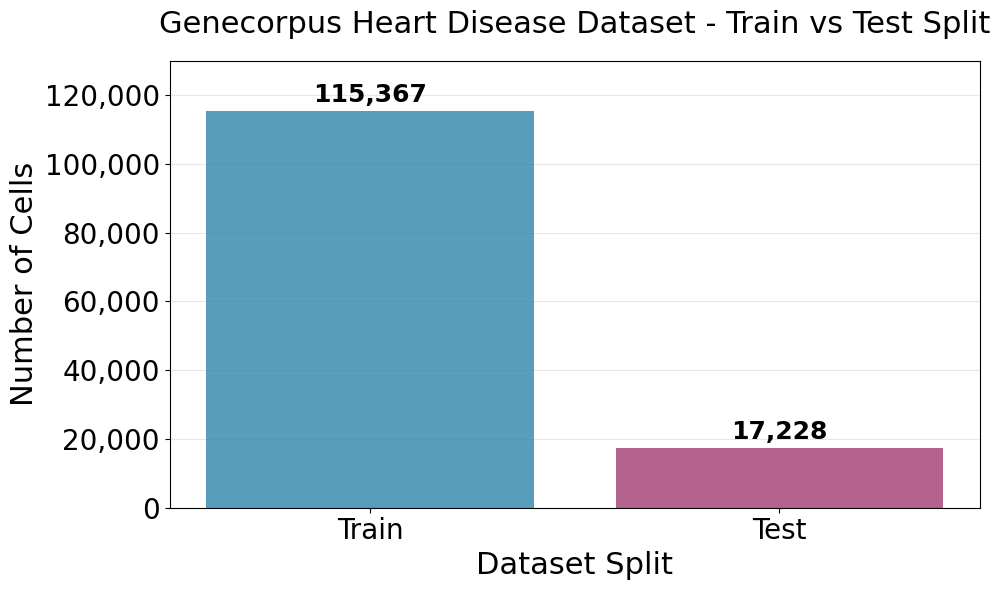

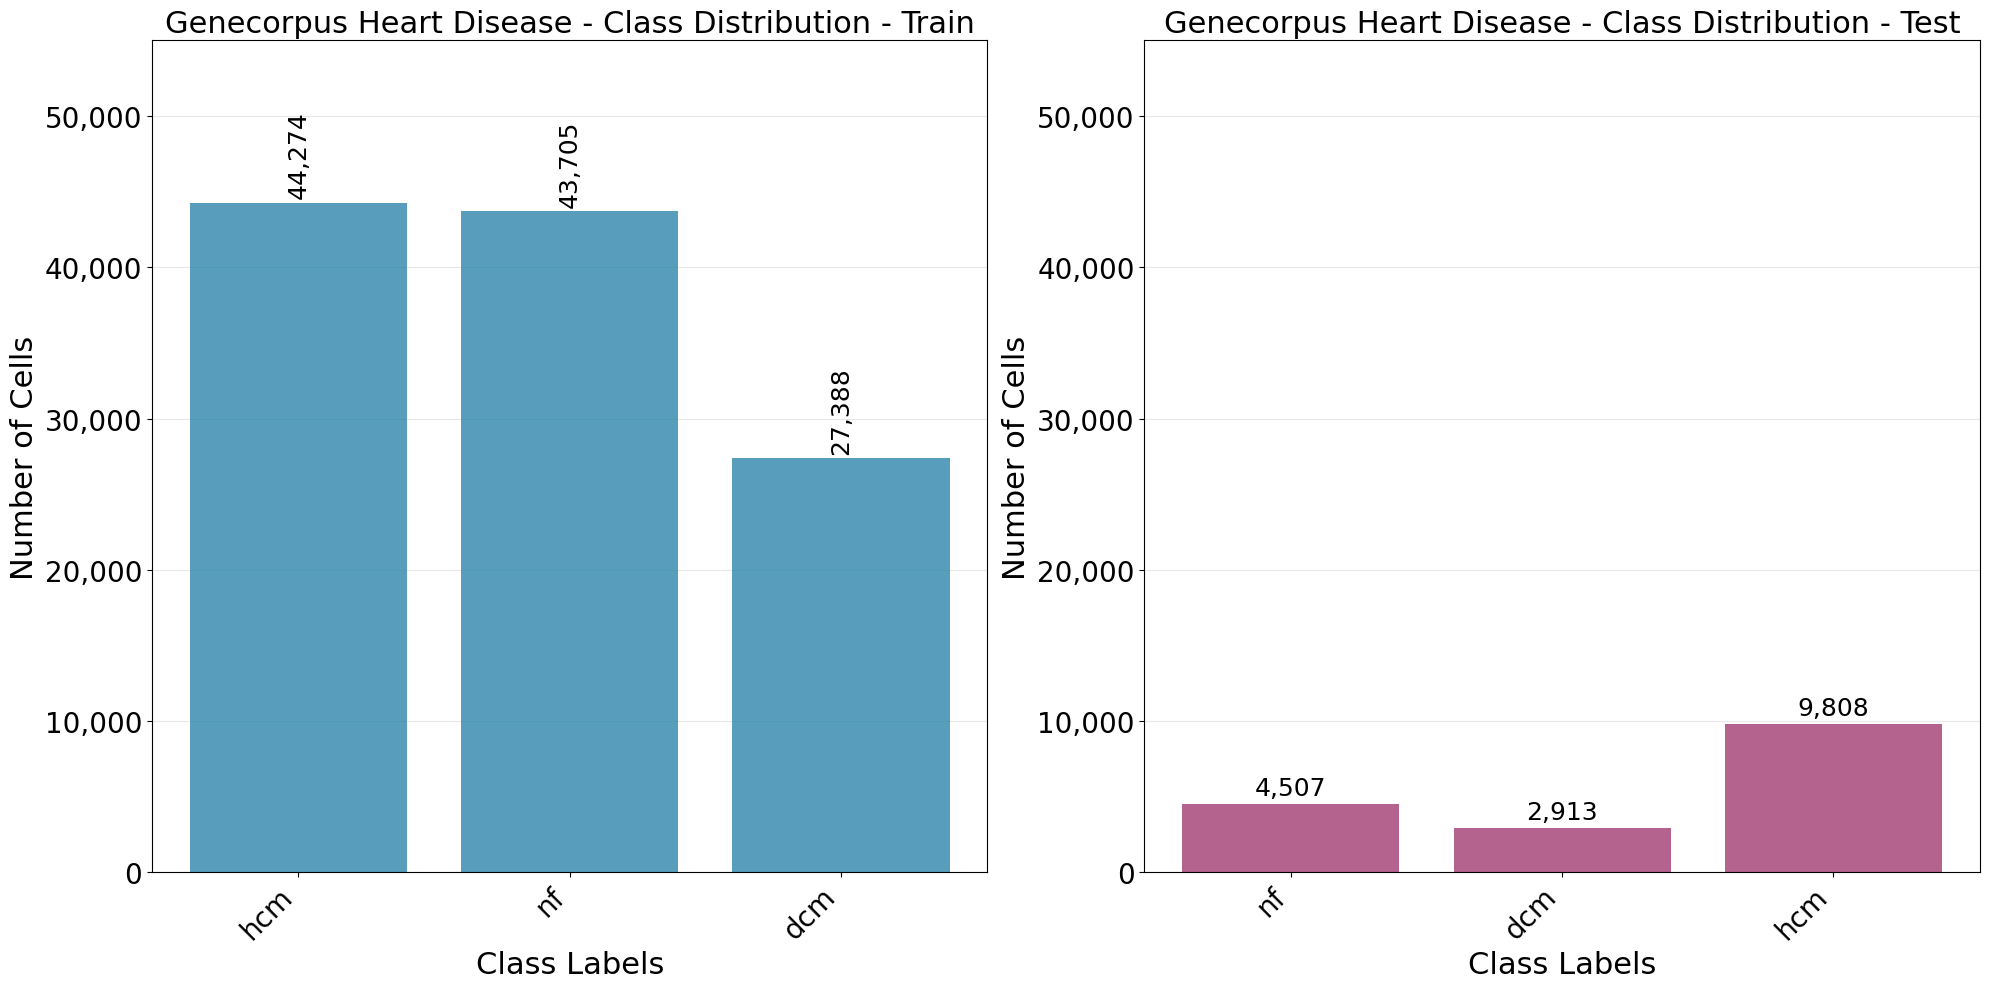

In [73]:
# Define custom text sizes
# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Define paths
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/disease_classification/genecorpus_heart_disease/30M_singlecell"
train_path = os.path.join(base_path, "genecorpus_heart_disease_test_labeled_train.dataset")
test_path = os.path.join(base_path, "genecorpus_heart_disease_test_labeled_test.dataset")

# Plot 1: Train vs Test comparison
fig1, ax1 = plot_train_test_comparison(
    train_path=train_path,
    test_path=test_path,
    title="Genecorpus Heart Disease Dataset - Train vs Test Split",
    text_sizes=custom_text_sizes,
    figsize=(10, 6),
    ylim=(0, 130000)  # None or set to (0, 1000000) for example
)
plt.show()

# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Plot 2: Class distribution
id_class_dict_path = os.path.join(base_path, "genecorpus_heart_disease_test_id_class_dict.pkl")
fig2, (ax2, ax3) = plot_class_distribution(
    train_path=train_path,
    test_path=test_path,
    id_class_dict_path=id_class_dict_path,
    title_prefix="Genecorpus Heart Disease - Class Distribution",
    text_sizes=custom_text_sizes,
    figsize=(20, 10),
    ylim=(0, 55000)  # None or set to (0, 500000) for example
)
plt.show()

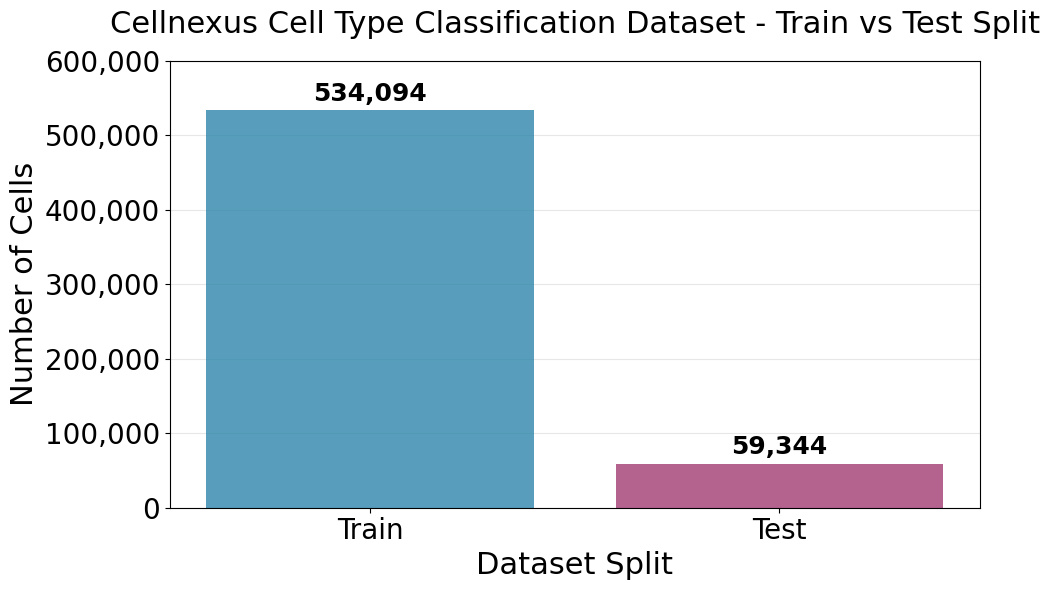

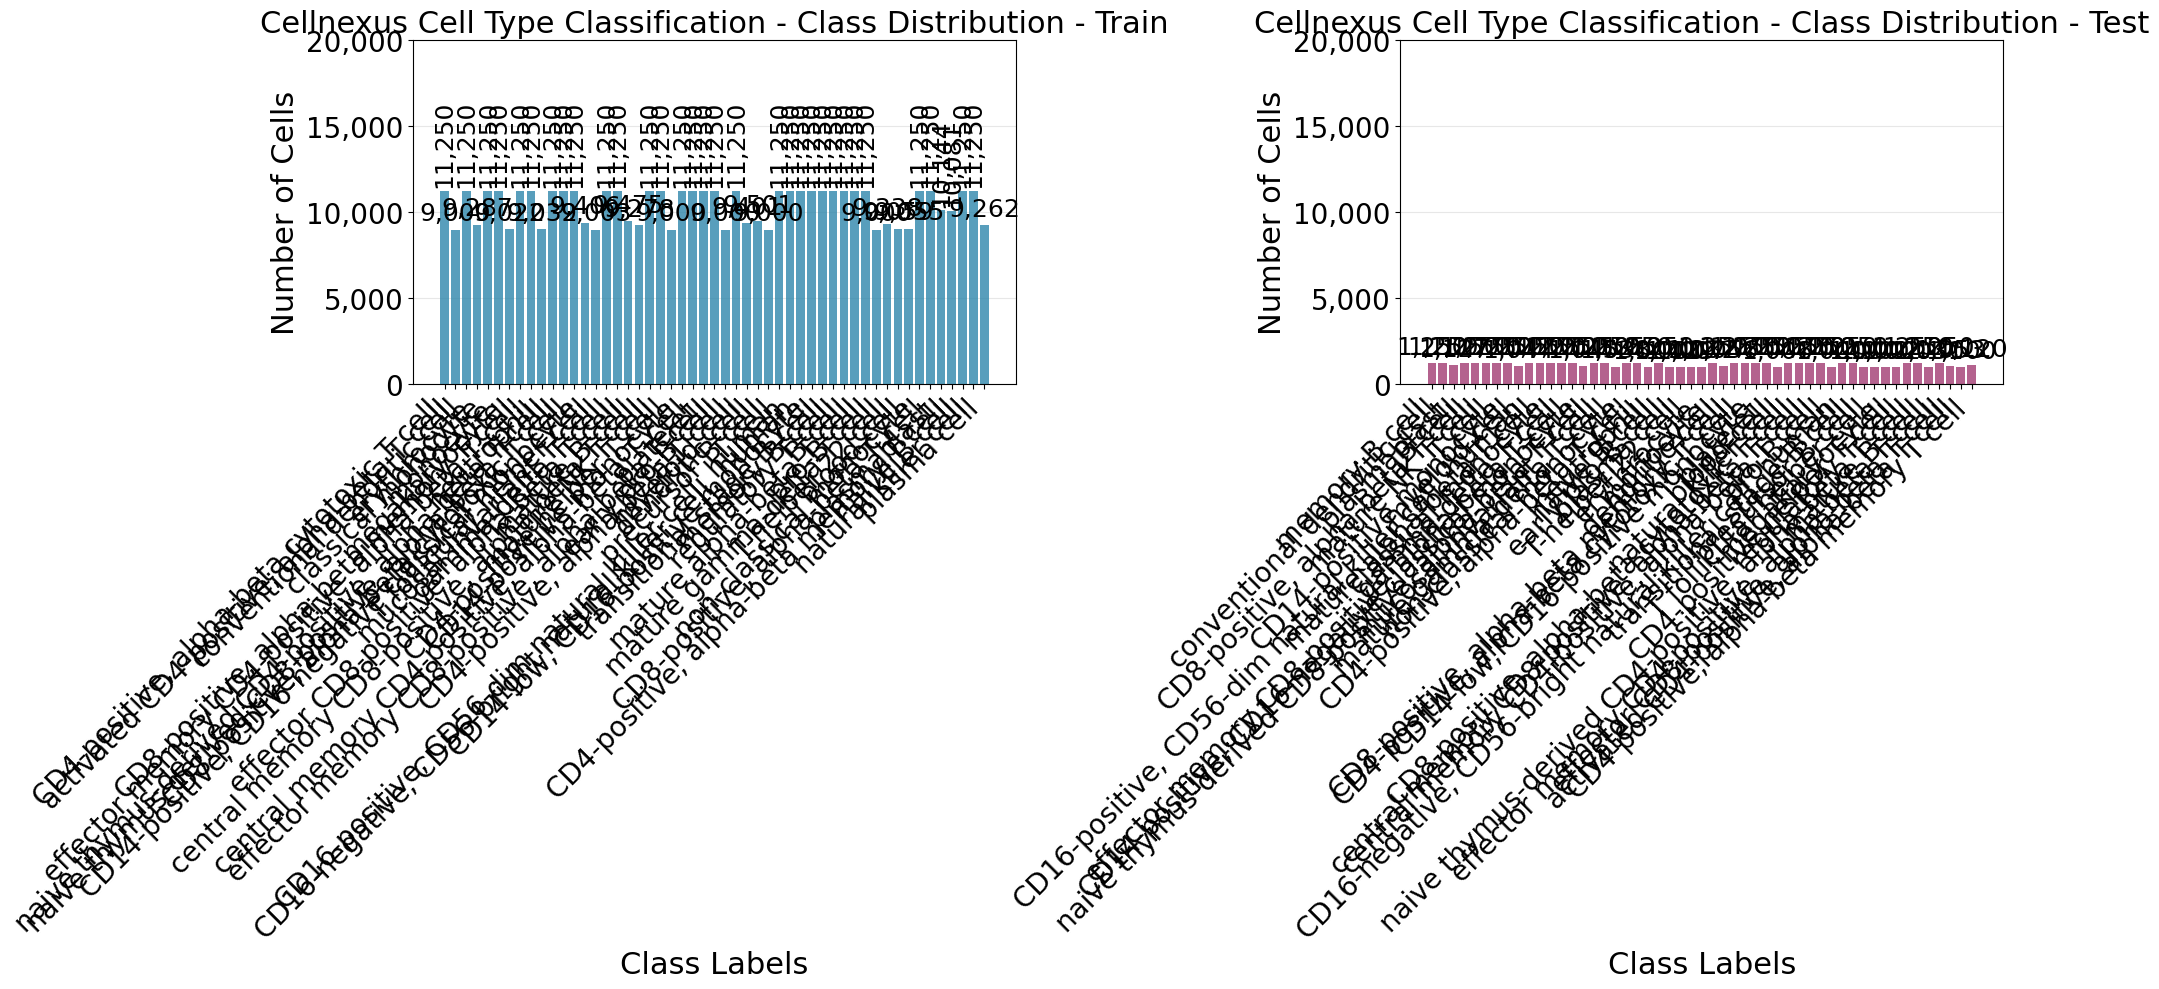

In [74]:
# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Define paths
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/trained_cell_classification_models/cell_type_classification/cellnexus_cell_types/30M_singlecell"
train_path = os.path.join(base_path, "cellnexus_cell_types_test_labeled_train.dataset")
test_path = os.path.join(base_path, "cellnexus_cell_types_test_labeled_test.dataset")

# Plot 1: Train vs Test comparison
fig1, ax1 = plot_train_test_comparison(
    train_path=train_path,
    test_path=test_path,
    title="Cellnexus Cell Type Classification Dataset - Train vs Test Split",
    text_sizes=custom_text_sizes,
    figsize=(10, 6),
    ylim=(0, 600000)  # None or set to (0, 1000000) for example
)
plt.show()

# Define custom text sizes
custom_text_sizes = {
    'title': 22,
    'axes_labels': 22, 
    'ticks': 20,
    'annotations': 18,
    'legend': 18
}

# Plot 2: Class distribution
id_class_dict_path = os.path.join(base_path, "cellnexus_cell_types_test_id_class_dict.pkl")
fig2, (ax2, ax3) = plot_class_distribution(
    train_path=train_path,
    test_path=test_path,
    id_class_dict_path=id_class_dict_path,
    title_prefix="Cellnexus Cell Type Classification - Class Distribution",
    text_sizes=custom_text_sizes,
    figsize=(20, 10),
    ylim=(0, 20000)  # None or set to (0, 500000) for example
)
plt.show()